## Importing necessary libraries and datasets

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,RobustScaler,LabelEncoder,PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
train=pd.read_csv('train.csv')
x_test=pd.read_csv('test.csv')

In [3]:
y_train=train['SalePrice']
x_train=train.drop(['SalePrice'],axis=1)

## Feature Importance

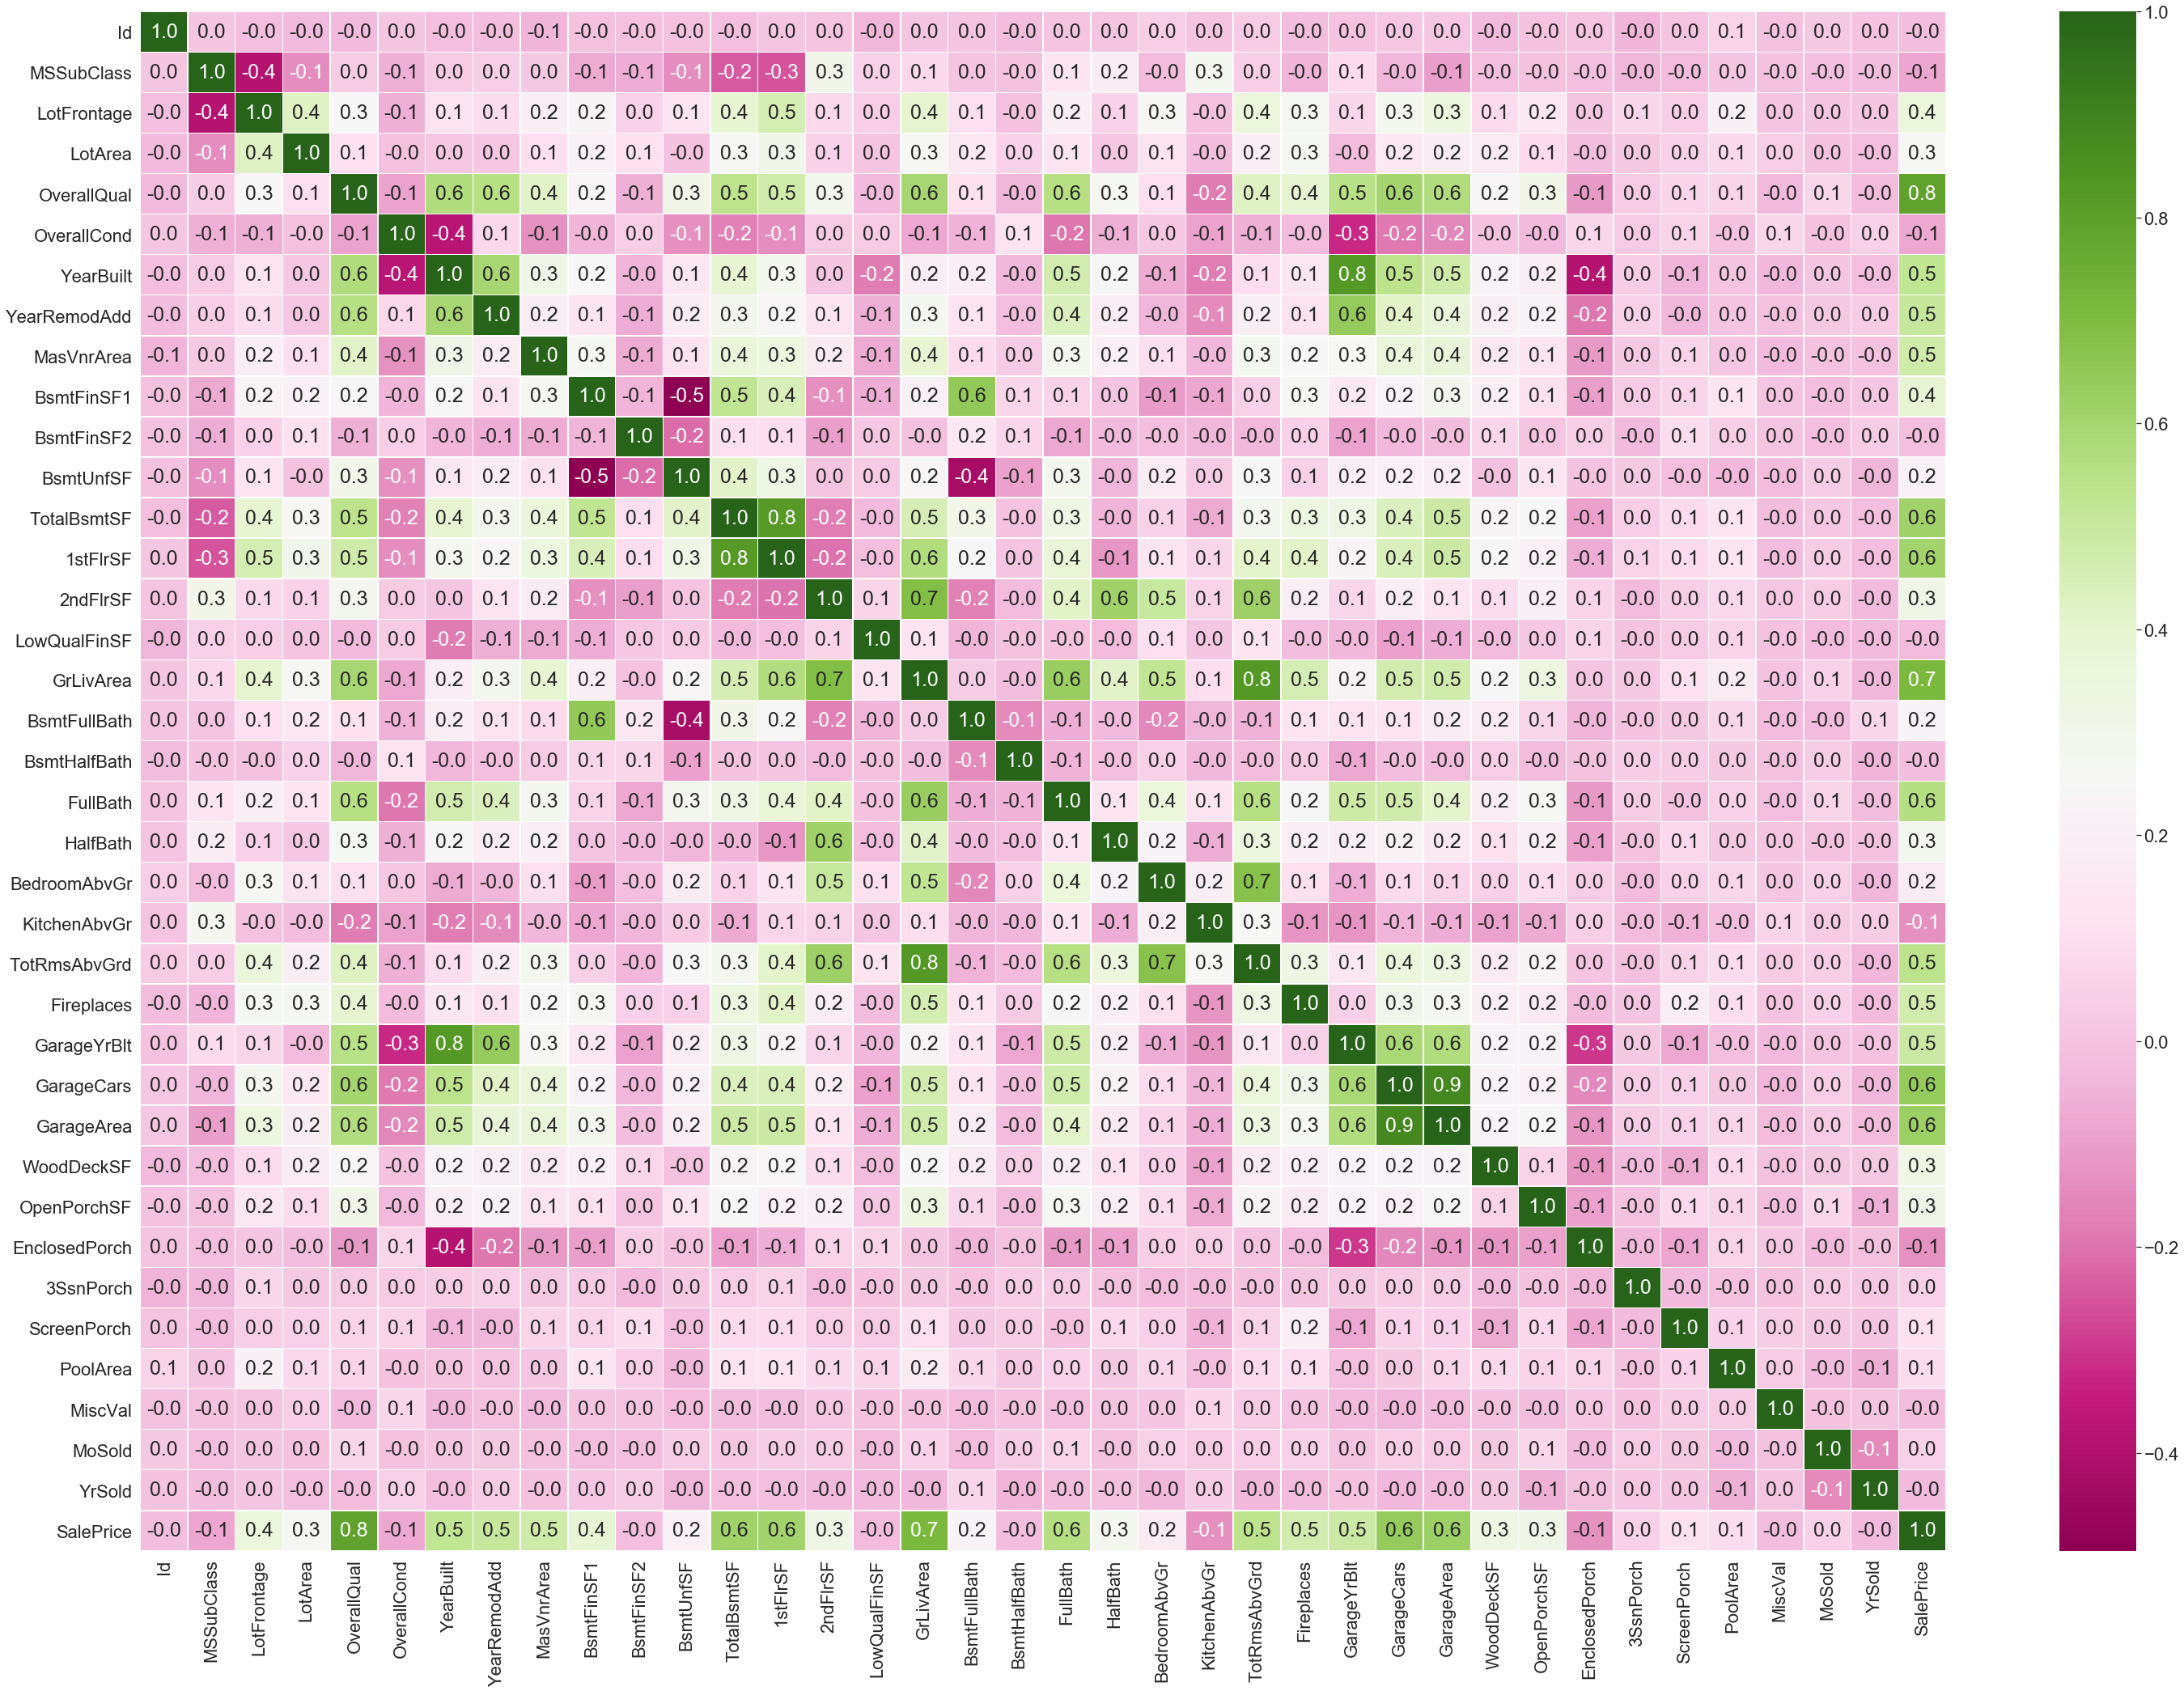

In [4]:
correlation_train=train.corr()
sb.set(font_scale=2)
plt.figure(figsize = (50,35))
ax = sb.heatmap(correlation_train, annot=True,annot_kws={"size": 25},fmt='.1f',cmap='PiYG', linewidths=.5)

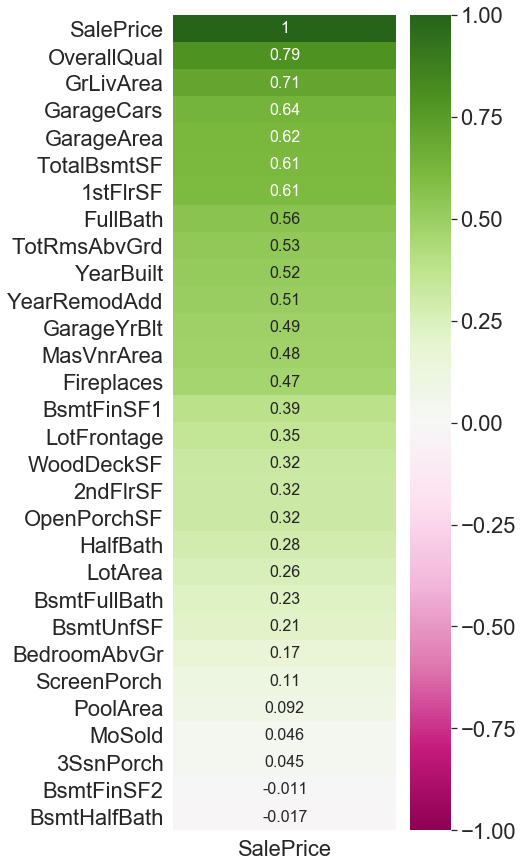

In [5]:
corr_new_train=train.corr()
plt.figure(figsize=(5,15))
sb.heatmap(corr_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30),annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
sb.set(font_scale=2)

In [6]:
corr_dict=corr_new_train['SalePrice'].sort_values(ascending=False).to_dict()
important_columns=[]
for key,value in corr_dict.items():
    if ((value>=0.3175) & (value<0.9)) | (value<=-0.315):
        important_columns.append(key)
important_columns

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'MasVnrArea',
 'Fireplaces',
 'BsmtFinSF1',
 'LotFrontage',
 'WoodDeckSF',
 '2ndFlrSF']

## Exploratory data analysis

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 <a list of 17 Text xticklabel objects>)

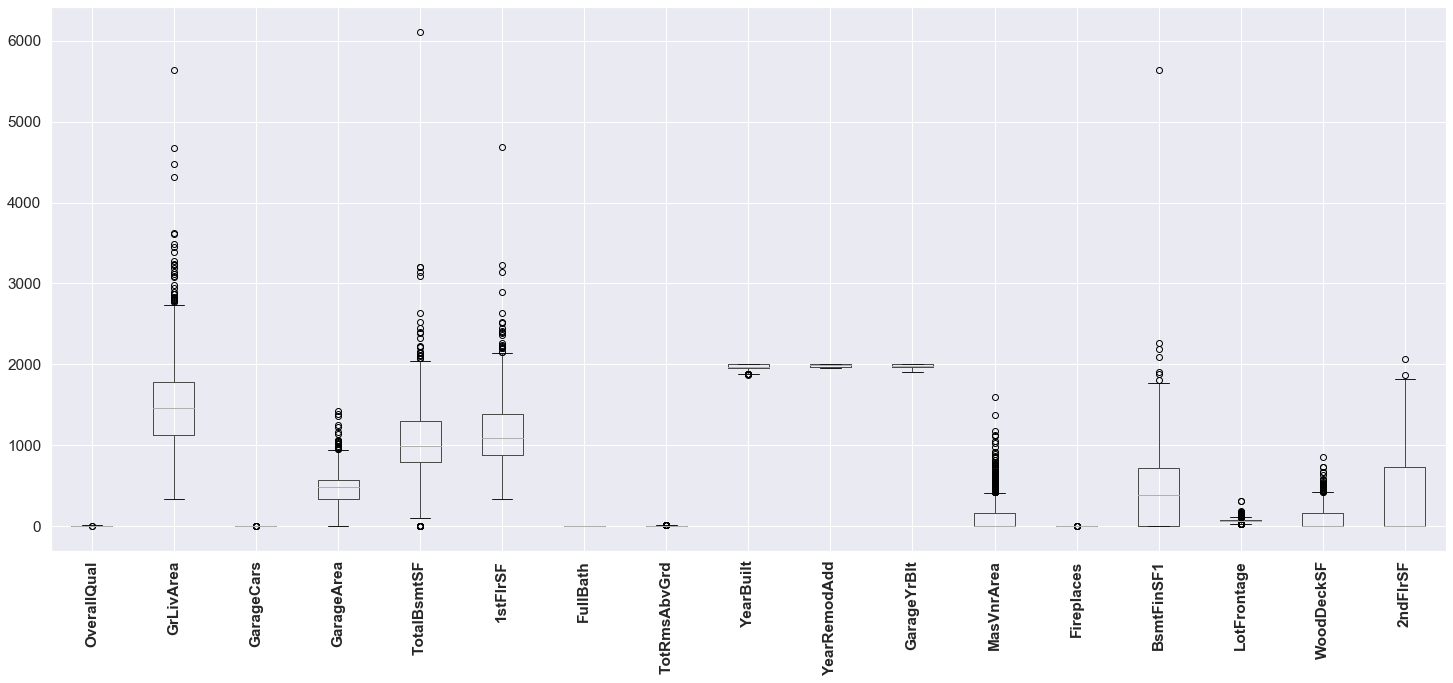

In [7]:
plt.figure(figsize=(25,10))
sb.set(font_scale=1.4)
train.boxplot(column=important_columns)
plt.xticks(weight='bold',rotation=90)

## Data skewness

Skew Dist: 1.8828757597682129
Kurtosis Dist: 6.536281860064529


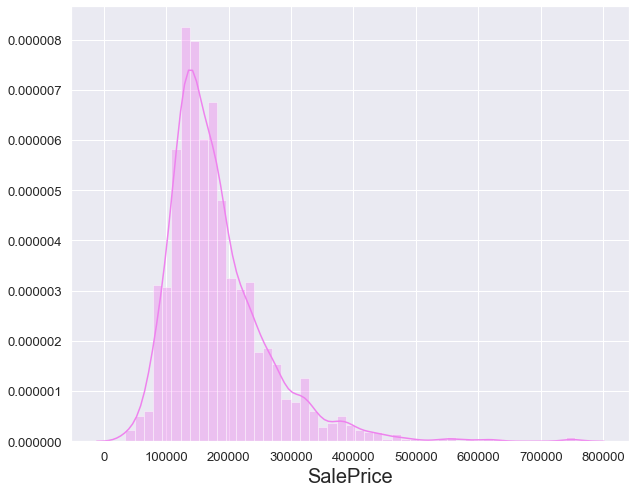

In [8]:
plt.figure(figsize=(10,8))
sb.set(font_scale=1.2)
sb.distplot(y_train,color='violet')
plt.xlabel('SalePrice',fontsize=20)
print('Skew Dist:',train['SalePrice'].skew())
print('Kurtosis Dist:',train['SalePrice'].kurt())

In [9]:
y_train = np.log1p(y_train)

Skew Dist: 0.12134661989685333
Kurtosis Dist: 0.809519155707878


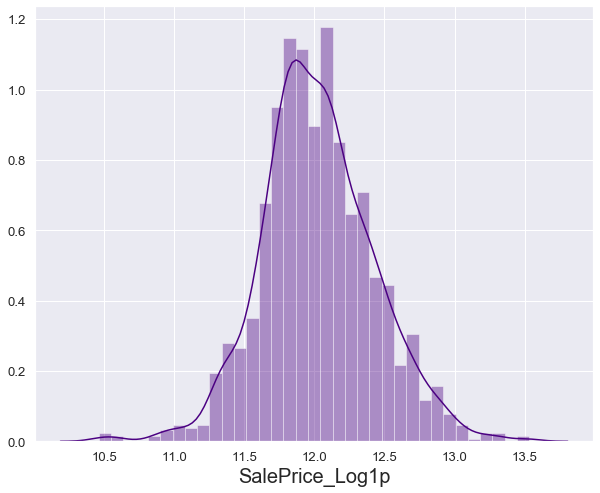

In [10]:
plt.figure(figsize=(10,8))
sb.set(font_scale=1.2)
sb.distplot(y_train,color='indigo')
plt.xlabel('SalePrice_Log1p',fontsize=20)
print('Skew Dist:',y_train.skew())
print('Kurtosis Dist:',y_train.kurt())

In [11]:
#Merging test and train data
df=[x_train,x_test]
df=pd.concat(df,ignore_index=True)
df=df.drop(['Id'],axis=1)

In [12]:

numeric_features = df.dtypes[df.dtypes != "object"].index
skewed_features = df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
print(skewed_features)

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
EnclosedPorch     4.003891
ScreenPorch       3.946694
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
MSSubClass        1.375457
GrLivArea         1.269358
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
OverallCond       0.570312
BedroomAbvGr      0.326324
OverallQual       0.197110
MoSold            0.195884
FullBath          0.167606
YrSold            0.132399
YearRemodAdd     -0.451020
YearBuilt        -0.599806
LotFrontage            NaN
MasVnrArea             NaN
BsmtFinSF1             NaN
BsmtFinSF2             NaN
BsmtUnfSF              NaN
TotalBsmtSF            NaN
BsmtFullBath           NaN
BsmtHalfBath           NaN
GarageYrBlt            NaN
GarageCars             NaN
GarageArea             NaN
dtype: float64


In [13]:
high_skewness = skewed_features[abs(skewed_features) > 0.9]
skewed_features = high_skewness.index

In [14]:
for feature in skewed_features:
    df[feature] = boxcox1p(df[feature], boxcox_normmax(df[feature] + 1))

## Removing overfitted features

In [15]:
def overfit_reducer(df):

    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.9:
            overfit.append(i)
    overfit = list(overfit)
    return overfit
overfitted_features = overfit_reducer(x_train)

In [16]:
df.drop(overfitted_features,axis=1,inplace=True)
print('X.shape',df.shape)

X.shape (2919, 78)


## Data Cleaning

In [17]:
df.isnull().sum().sort_values(ascending=False)

PoolQC         2909
MiscFeature    2814
Alley          2721
Fence          2348
FireplaceQu    1420
               ... 
2ndFlrSF          0
1stFlrSF          0
CentralAir        0
Heating           0
MSSubClass        0
Length: 78, dtype: int64

In [18]:
df['MSSubClass'] = df['MSSubClass'].astype(str)
#CHANGE
for col in df.columns:
    if df[col].dtype==np.object:
        df[col]=df[col].fillna('NA')
for col in df.columns:
    if df[col].dtype==np.float64:
        df[col]=df[col].fillna(df[col].mean())

## Encoding

In [19]:
columns = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'YrSold', 'MoSold', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond')

for col in columns:
    lbl_enc = LabelEncoder() 
    lbl_enc.fit(list(df[col].values)) 
    df[col] = lbl_enc.transform(list(df[col].values))

In [20]:
df=pd.get_dummies(df)

In [21]:
df.shape

(2919, 226)

## Scaling Data

In [22]:
scaled_df=StandardScaler().fit_transform(df.values)
scaled_df = pd.DataFrame(scaled_df, index=df.index, columns=df.columns)

In [23]:
x_train=scaled_df[:1460]
x_test=scaled_df[1460:]

In [24]:
x_traint,x_testt,y_traint,y_testt=train_test_split(x_train,y_train,test_size=0.1,random_state=10)

## Modelling

In [25]:
'''
data_dmatrix = xgb.DMatrix(data=x_train,label=y_train_log)data_dmatrix = xgb.DMatrix(data=x_train,label=y_train_log)
param = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'alpha':range(1,20,1),
    'colsample_bytree':range(0,5,1)
}

grid_xgb = GridSearchCV(xg_reg, param_grid=param, cv=10)
'''

"\ndata_dmatrix = xgb.DMatrix(data=x_train,label=y_train_log)data_dmatrix = xgb.DMatrix(data=x_train,label=y_train_log)\nparam = {\n    'max_depth': range (2, 10, 1),\n    'n_estimators': range(60, 220, 40),\n    'learning_rate': [0.1, 0.01, 0.05],\n    'alpha':range(1,20,1),\n    'colsample_bytree':range(0,5,1)\n}\n\ngrid_xgb = GridSearchCV(xg_reg, param_grid=param, cv=10)\n"

In [26]:
#grid_xgb.fit(x_traint, y_traint)

In [27]:
#grid_xgb.best_params_

In [28]:
xg_reg_gs = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.1, learning_rate = 0.01,
                max_depth = 4, alpha = 10, n_estimators = 10000,random_state=42)

In [29]:
xg_reg_gs.fit(x_traint,y_traint)
y_pred = xg_reg_gs.predict(x_testt)
print('-'*10+'XGBoost'+'-'*10)
print('R square Accuracy: ',r2_score(y_testt,y_pred))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_testt,y_pred))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_testt,y_pred))

----------XGBoost----------
R square Accuracy:  0.9032083062424554
Mean Absolute Error Accuracy:  0.09001050873105723
Mean Squared Error Accuracy:  0.014102914194907232


In [30]:
gb_reg = GradientBoostingRegressor(n_estimators=1992, learning_rate=0.03005, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=14, loss='huber', random_state =42)
gb_reg.fit(x_traint, y_traint)
y_pred=gb_reg.predict(x_testt)
print('-'*10+'GBR'+'-'*10)
print('R square Accuracy: ',r2_score(y_testt,y_pred))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_testt,y_pred))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_testt,y_pred))

----------GBR----------
R square Accuracy:  0.9351461871707515
Mean Absolute Error Accuracy:  0.06640047991135675
Mean Squared Error Accuracy:  0.009449444699609613


In [31]:
from sklearn.pipeline import make_pipeline
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas=[1e-9,1e-8,1e-7,1e-6]

ridgecv_reg= make_pipeline(RidgeCV(alphas=alphas, cv=kfolds))
ridgecv_reg.fit(x_traint, y_traint)
y_pred=ridgecv_reg.predict(x_testt)
print('-'*10+'RidgeCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_testt,y_pred))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_testt,y_pred))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_testt,y_pred))

----------RidgeCV----------
R square Accuracy:  0.9266754161229189
Mean Absolute Error Accuracy:  0.07619182872540958
Mean Squared Error Accuracy:  0.010683667933180978


In [32]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

lassocv_reg= make_pipeline(LassoCV(alphas=alphas, cv=kfolds))
lassocv_reg.fit(x_traint, y_traint)
y_pred=lassocv_reg.predict(x_testt)
print('-'*10+'LassoCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_testt,y_pred))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_testt,y_pred))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_testt,y_pred))

----------LassoCV----------
R square Accuracy:  0.9269254211745327
Mean Absolute Error Accuracy:  0.07587356704379328
Mean Squared Error Accuracy:  0.010647241255908088


In [33]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006]
l1ratio=[0.87, 0.9,0.92, 0.95,0.97, 0.99, 1]

elasticv_reg= make_pipeline(ElasticNetCV(alphas=alphas, cv=kfolds, l1_ratio=l1ratio))
elasticv_reg.fit(x_traint, y_traint)
y_pred=elasticv_reg.predict(x_testt)
print('-'*10+'ElasticNetCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_testt,y_pred))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_testt,y_pred))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_testt,y_pred))

----------ElasticNetCV----------
R square Accuracy:  0.9314074384179316
Mean Absolute Error Accuracy:  0.07320926891220741
Mean Squared Error Accuracy:  0.009994194469041397


In [34]:
import lightgbm as lgb
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
lgb_regressor=lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.035, n_estimators=2177, max_bin=50, bagging_fraction=0.65,bagging_freq=5, bagging_seed=7, 
                                feature_fraction=0.201, feature_fraction_seed=7,n_jobs=-1)
lgb_regressor.fit(x_traint, y_traint)
y_pred=lgb_regressor.predict(x_testt)
print('-'*10+'LGBM'+'-'*10)
print('R square Accuracy: ',r2_score(y_testt,y_pred))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_testt,y_pred))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_testt,y_pred))

----------LGBM----------
R square Accuracy:  0.9238552595533243
Mean Absolute Error Accuracy:  0.07314303952753592
Mean Squared Error Accuracy:  0.01109457536307703


In [35]:
estimators = [('xgb', xg_reg_gs),
              ('lgbm', lgb_regressor),
              ('gbr', gb_reg),   
              ('lasso', lassocv_reg),   
              ('ridge', ridgecv_reg),   
              ('elasticnet', elasticv_reg)]

stack_reg=StackingRegressor(estimators=estimators,final_estimator=ExtraTreesRegressor(n_estimators=50),n_jobs=-1)
stack_reg.fit(x_traint, y_traint)
y_pred=stack_reg.predict(x_testt)
print('-'*10+'StackingRegressor'+'-'*10)
print('R square Accuracy: ',r2_score(y_testt,y_pred))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_testt,y_pred))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_testt,y_pred))

----------StackingRegressor----------
R square Accuracy:  0.9260891568746527
Mean Absolute Error Accuracy:  0.07417845428538003
Mean Squared Error Accuracy:  0.01076908811288132


In [36]:
y_pred =np.floor(np.expm1(y_pred))

## Submission

In [ ]:
dg = pd.DataFrame({'Id':x_test.index,'SalePrice': y_pred_exp},index=x_test.index)

In [ ]:
dg['Id']=dg['Id']+1

In [ ]:
dg.to_csv('ver8.csv',index=False)

In [ ]:
dg